# Lab 3: Support Vector Machines

### Machine Learning 1, September/October 2023

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* use the provided test boxes to check if your answers are correct

In [1]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

## Support Vector Machines (40 points)
As seen in Part 1: Gaussian Processes, one of the significant limitations of many such algorithms is that the kernel function $k(\mathbf{x}_n , \mathbf{x}_m)$ must be evaluated for all possible pairs $\mathbf{x}_n$ and $\mathbf{x}_m$ of training points, which can be computationally infeasible during training and can lead to excessive computation times when making predictions for new data points.
In Part 2: Support Vector Machines, we shall look at kernel-based algorithms that have sparse solutions, so that predictions for new inputs depend only on the kernel function evaluated at a subset of the training data points. We are using the same notation as in Bishop chapter 7.

### Generating a linearly separable dataset (15 points)
a) (5 points) First of all, we are going to create our own 2D toy dataset $X$. The dataset will consists of two i.i.d. subsets $X_1$ and $X_2$, each of the subsets will be sampled from a multivariate Gaussian distribution,

\begin{align}
X_1 \sim &\mathcal{N}(\mu_1, \Sigma_1)\\
&\text{ and }\\
X_2 \sim &\mathcal{N}(\mu_2, \Sigma_2).
\end{align}

In the following, $X_1$ will have $N_1=20$ samples and a mean $\mu_1=(1,1)$. $X_2$ will have $N_2=30$ samples and a mean $\mu_2=(3,3)$.

Plot the two subsets in one figure, choose two colors to indicate which sample belongs to which subset. In addition you should choose, $\Sigma_1$ and $\Sigma_2$ in a way that the two subsets become linearly separable. (5 points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# YOUR CODE HERE

# Red
N1 = 50
mean1 = np.array([1,1])
Sigma1 = np.array([[1.2, -0.95], [-0.95, 1.2]])
X1 = np.random.multivariate_normal(mean1, Sigma1, N1)

# Blue
N2 = 30
mean2 = np.array([3,3])
Sigma2 = np.array([[1.2, -0.95], [-0.95, 1.2]])
X2 = np.random.multivariate_normal(mean2, Sigma2, N2)

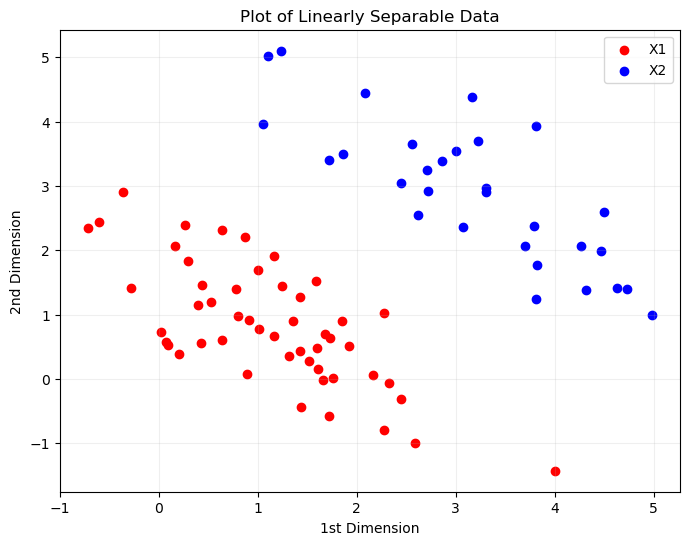

In [111]:
# Plot your data
plt.figure(figsize=(8, 6))
plt.scatter(X1[:,0], X1[:,1], c='r', label="X1")
plt.scatter(X2[:,0], X2[:,1], c='b', label="X2")
plt.title('Plot of Linearly Separable Data')
plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

b) (10 points) In the next step we will combine the two datasets X_1, X_2 and generate a vector `t` containing the labels. Write a function `create_X_and_t(X1, X2)` it should return the combined data set X and the corresponding target vector t.

In [5]:
def create_X_and_t(X1, X2):
    # YOUR CODE HERE

    X = np.concatenate((X1, X2))
    t1 = np.ones(X1.shape[0], dtype=int)
    t2 = -1 * np.ones(X2.shape[0], dtype=int)
    t = np.concatenate((t1,t2))
    
    return X, t 

In [6]:
### Test your function
dim = 2
N1_test = 3
N2_test = 4
X1_test = np.arange(6).reshape((N1_test, dim))
X2_test = np.arange(8).reshape((N2_test, dim))
X_test, t_test = create_X_and_t(X1_test, X2_test)

assert X_test.shape == (N1_test + N2_test, dim), "the shape of X is incorrect"
assert t_test.shape == (N1_test + N2_test,), "the shape of t is incorrect"

##### Finding the support vectors (25 points)
Finally we going to use a SVM to obtain the decision boundary for which the margin is maximized. We have to solve the optimization problem

\begin{align}
\arg \min_{\mathbf{w}, b} \frac{1}{2} \lVert \mathbf{w} \rVert^2,
\end{align}

subject to the constraints

\begin{align}
t_n(\mathbf{w}^T \phi(\mathbf{x}_n) + b) \geq 1, n = 1,...,N.
\end{align}

In order to solve this constrained optimization problem, we introduce Lagrange multipliers $a_n \geq 0$. We obtain the dual
representation of the maximum margin problem in which we maximize

\begin{align}
\sum_{n=1}^N a_n - \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m),
\end{align}

with respect to a subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\sum_{n=1}^N a_n t_n &= 0.
\end{align}

This takes the form of a quadratic programming problem in which we optimize a quadratic function of $\mathbf{a}$, subject to a set of inequality constraints.



a) (5 points) In this example we will use a linear kernel $k(\mathbf{x}, \mathbf{x}') = \mathbf{x}^T\mathbf{x}'$. Write a function `computeK(X)` that computes the kernel matrix $K$ for the 2D dataset $X$.

In [7]:
def computeK(X):
    # YOUR CODE HERE
    K = X @ X.T
    return K

In [8]:
dim = 2
N_test = 3
X_test = np.arange(2, 8).reshape((N_test, dim))
K_test = computeK(X_test)

assert K_test.shape == (N_test, N_test)


Next, we will rewrite the dual representation so that we can make use of computationally efficient vector-matrix multiplication. The objective becomes

\begin{align}
\min_{\mathbf{a}} \frac{1}{2} \mathbf{a}^T K' \mathbf{a} - 1^T\mathbf{a},
\end{align}

subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\mathbf{t}^T\mathbf{a} &= 0.
\end{align}

Where
\begin{align}
K'_{nm} = t_n t_m k(\mathbf{x}_n, \mathbf{x}_m),
\end{align}
and in the special case of a linear kernel function,
$$
\begin{align}
K'_{nm} = t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) = k(t_n \mathbf{x}_n, t_m \mathbf{x}_m)
\end{align}
$$
To solve the quadratic programming problem we will use a python module called cvxopt. You first have to install the module in your virtual environment (you have to activate it first), using the following command:

`conda install -c anaconda cvxopt`

After the installation you probably have to restart Jupyter.

The quadratic programming solver can be called as

`cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])`

This solves the following problem,

\begin{align}
\min_{\mathbf{x}} \frac{1}{2} \mathbf{x}^T P \mathbf{x} + q^T\mathbf{x},
\end{align}

subject to the constraints,

\begin{align}
G\mathbf{x} &\leq h,\\
A\mathbf{x} &= b.
\end{align}

All we need to do is to map our formulation to the cvxopt interface.

b) (15 points) Write a function `compute_multipliers(X, t)` that solves the quadratic programming problem using the cvxopt module and returns the lagrangian multiplier for every sample in the dataset. Consider that your langrange multipliers will take vector greater than zero (given the numerical approacimations greater than a theshold).

In [28]:
import cvxopt

def compute_multipliers(X, t):
    # YOUR CODE HERE

    K = computeK(X)
    P = np.outer(t,t) * K
    P = cvxopt.matrix(P.astype('float'))
    
    # Number of data points
    n = X.shape[0]
    q = -np.ones((n, 1))
    q = cvxopt.matrix(q)

    # Diagonal of neg ones
    G = -np.eye(n)
    G = cvxopt.matrix(G)

    # Constrains of zeros
    h = np.zeros(n)
    h = cvxopt.matrix(h)

    # Linear matrix equation at constraint
    A = t.reshape((n,1)).T  
    A = cvxopt.matrix(A.astype('float'))
    b = np.zeros((1,1))
    b = cvxopt.matrix(b)

    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    a = np.array(sol['x'])
    return a

In [29]:
### Test your function
dim = 2
N_test = 3
X_test = np.arange(2, 8).reshape((N_test, dim))
t_test = np.array([-1., 1., 1.])
a_test = compute_multipliers(X_test, t_test)

assert a_test.shape == (N_test, 1)

     pcost       dcost       gap    pres   dres
 0: -7.2895e-01 -1.3626e+00  6e+00  2e+00  2e+00
 1: -3.0230e-01 -6.8816e-01  8e-01  1e-01  1e-01
 2: -2.3865e-01 -3.3686e-01  1e-01  8e-17  3e-15
 3: -2.4973e-01 -2.5198e-01  2e-03  9e-19  2e-15
 4: -2.5000e-01 -2.5002e-01  2e-05  6e-17  4e-16
 5: -2.5000e-01 -2.5000e-01  2e-07  8e-17  2e-15
Optimal solution found.


### Plot support vectors
Now that we have obtained the lagrangian multipliers $\mathbf{a}$, we use them to find our support vectors. Repeat the plot from 2.1, this time use a third color to indicate which samples are the support vectors.

     pcost       dcost       gap    pres   dres
 0: -7.9849e+00 -1.3867e+01  2e+02  1e+01  2e+00
 1: -6.3980e+00 -3.0620e+00  2e+01  2e+00  2e-01
 2: -5.8577e-01 -1.7138e+00  1e+00  3e-15  7e-15
 3: -1.0684e+00 -1.3416e+00  3e-01  2e-15  2e-15
 4: -1.2933e+00 -1.3193e+00  3e-02  1e-15  3e-15
 5: -1.3170e+00 -1.3173e+00  3e-04  3e-16  3e-15
 6: -1.3172e+00 -1.3173e+00  3e-06  5e-16  3e-15
 7: -1.3173e+00 -1.3173e+00  3e-08  6e-16  3e-15
Optimal solution found.


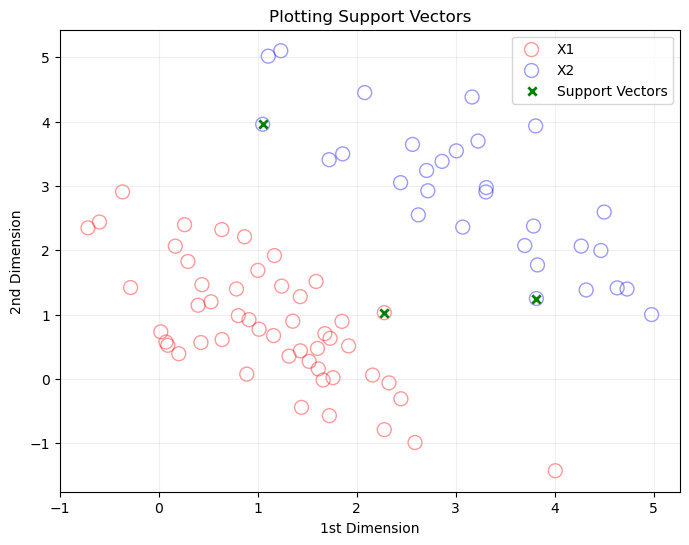

In [97]:
# YOUR CODE HERE
X, t = create_X_and_t(X1, X2)
a = compute_multipliers(X, t)
sv_indices = (a > 1e-4).squeeze() 
SV = X[sv_indices]

# Plot your data
plt.figure(figsize=(8, 6))
plt.scatter(X1[:,0], X1[:,1], label="X1",  s=100, facecolors='none', edgecolors='r', alpha=0.4)
plt.scatter(X2[:,0], X2[:,1], label="X2",  s=100, facecolors='none', edgecolors='b', alpha=0.4)
plt.scatter(SV[:,0], SV[:,1], c='g', label="Support Vectors", marker='x', linewidths=2)
plt.title('Plotting Support Vectors')
plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

### Plot the decision boundary (10 Points)
The decision boundary is fully specified by a (usually very small) subset of training samples, the support vectors. Make use of

\begin{align}
\mathbf{w} &= \sum_{n=1}^N a_n t_n \mathbf{\phi}(\mathbf{x}_n)\\
b &= \frac{1}{N_S}\sum_{n \in S} (t_n - \sum_{m \in S} a_m t_m k(\mathbf{x}_n, \mathbf{x}_m)),
\end{align}

where $S$ denotes the set of indices of the support vectors, to calculate the slope and intercept of the decision boundary. Generate a last plot that contains the two subsets, support vectors and decision boundary.

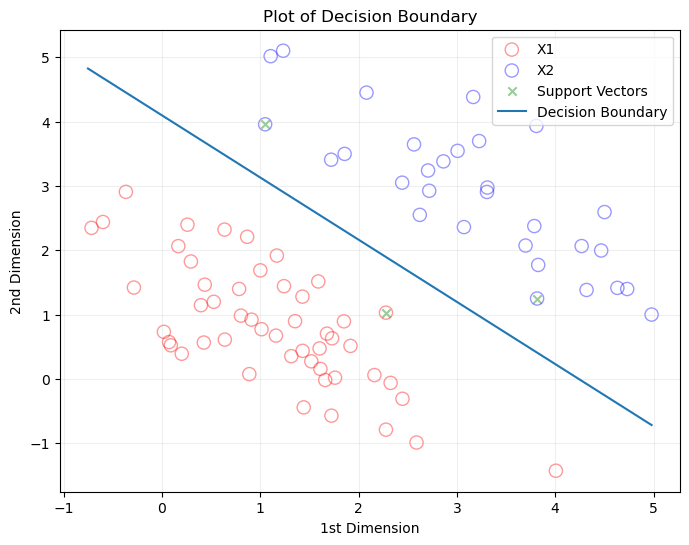

In [119]:
# YOUR CODE HERE
t = np.reshape(t, (-1, 1))
w = (X.T).dot(a * t) 

# extract t's that belongs to SV
t_sv = t[sv_indices]

# compute K only for SV's
K_sv = computeK(SV)

# compute b
N_sv = t_sv.shape[0]
a_sv = a[sv_indices]
b = 1/N_sv * np.sum(t_sv - ( K_sv @ (t_sv * a_sv)) )

# calculate cord for decision boundary
x_max = np.max(X, axis = 0)
x_min = np.min(X, axis = 0)
y_max = -w[0] / w[1] * x_max[0] - b / w[1]
y_min = -w[0] / w[1] * x_min[0] - b / w[1]

ptA = np.array([x_max[0], y_max], dtype='object')
ptB = np.array([x_min[0], y_min], dtype='object')

# Plot your data
plt.figure(figsize=(8, 6))
plt.scatter(X1[:,0], X1[:,1], label="X1",  s=90, facecolors='none', edgecolors='r', alpha=0.4)
plt.scatter(X2[:,0], X2[:,1], label="X2",  s=90, facecolors='none', edgecolors='b', alpha=0.4)
plt.scatter(SV[:,0], SV[:,1], c='g', label="Support Vectors", marker='x', alpha=0.4)
plt.plot(ptA, ptB, label="Decision Boundary")
plt.title('Plot of Decision Boundary')
plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')
plt.legend()
plt.grid(alpha=0.2)
plt.show()
